In [1]:
# Standard libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot stuff
from matplotlib.patches import ConnectionPatch

# Loadingbar
from tqdm.notebook import tqdm

In [2]:
# Import my own functions developed for AppStat2020
import sys

# Load own library
sys.path.append('../AppStat_Functions')
import General_functions as AppStars

In [3]:
SaveFig = True

# Import Data

In [4]:
data = np.loadtxt('Data/Exam_2022_Problem2.txt')
azim = data[:,0] #in radians
zeni = data[:,1]

# Visualize the Data

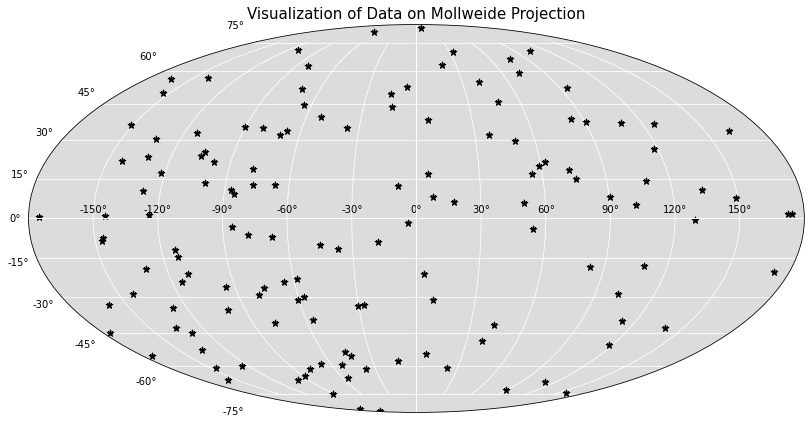

In [5]:
# Make figure with right projection
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': 'mollweide'})

# Background and gridlines
ax.set_facecolor('gainsboro')
ax.grid(color='white')
# Meridian - zenith angle from 0rad to pi (0deg to 180 deg) -pi/2 so instead goes from -pi to pi
meridian = np.stack([np.zeros(100), np.linspace(0,np.pi,100) - np.pi/2], axis=1)
# Equator from 0 rad to 2pi - pi
equator = np.stack([np.linspace(0,2*np.pi,100) - np.pi, np.zeros(100)], axis=1)
# Display it
ax.plot(equator[:,0], equator[:,1], lw=1, color='w')
ax.plot(meridian[:,0], meridian[:,1], lw=1, color='w')

# Plot the data
ax.scatter(azim-np.pi, -zeni+np.pi/2, marker='*', color='k', s=50, zorder=2)

# Title
ax.set_title('Visualization of Data on Mollweide Projection', fontsize=15)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/2a_1.pdf')

plt.show()

# Problem (2A)

## Simulate Isotropic Data MC
Isotropic data is uniformly distributed both in the azimuth angle with range (0,2pi) and in cos(zenith angle) with range (-1,1). We will randomly sample as many points as is in the data set from these distributions.

In [6]:
# Sample from distributions
np.random.seed(1)
N_points = len(data)
MC_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points)
MC_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points)
MC_zeni = np.arccos(MC_cos_zeni)

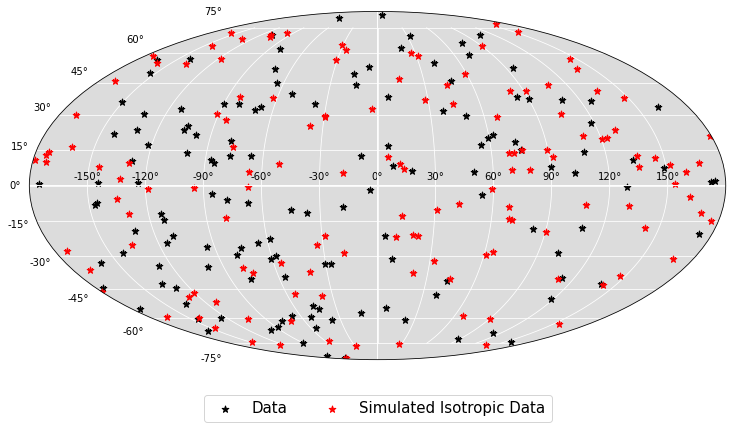

In [7]:
# Make figure with right projection
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': 'mollweide'})

# Background and gridlines
ax.set_facecolor('gainsboro')
ax.grid(color='white')
# Meridian - zenith angle from 0rad to pi (0deg to 180 deg) -pi/2 so instead goes from -pi to pi
meridian = np.stack([np.zeros(100), np.linspace(0,np.pi,100) - np.pi/2], axis=1)
# Equator from 0 rad to 2pi - pi
equator = np.stack([np.linspace(0,2*np.pi,100) - np.pi, np.zeros(100)], axis=1)
# Display it
ax.plot(equator[:,0], equator[:,1], lw=1, color='w')
ax.plot(meridian[:,0], meridian[:,1], lw=1, color='w')

# Plot the data
ax.scatter(azim-np.pi, -zeni+np.pi/2, marker='*', color='k', s=50, zorder=2, label='Data')

# Plot the simulated sample
ax.scatter(MC_azim-np.pi, -MC_zeni+np.pi/2, marker='*', color='r', s=50, zorder=2, 
           label='Simulated Isotropic Data')

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fancybox=True, prop={'size':15})

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/2a_2.pdf')
    
plt.show()

## Two Point Auto-Correlation Function
We now calculate the two point auto-correlation function, so we can compare them with a KS-test later.

See lecture: https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2022/Lecture_AhlersKoskinen2022.pdf slide 28 for the formula.

In [8]:
# Define a function that calculate 2pointcorr
def two_point_func(azim_arr, zeni_arr):
    
    # Define number of points
    N_tot = len(azim_arr)
    
    # Convert each point into cartesian coordinates (get unit vectors: r=1)
    r = 1
    Nx_arr = r * np.cos(azim_arr) * np.sin(zeni_arr)
    Ny_arr = r * np.sin(azim_arr) * np.sin(zeni_arr)
    Nz_arr = r * np.cos(zeni_arr)
    
    #Defining the range of cos phi's (x-axis)
    N_bins = 50
    cos_phi_bins = np.linspace(-1, 1, N_bins)

    # Array to store angular distance pairs, i.e. all cos_phi_ij
    cos_phi_ij_arr = []
    
    # Loop over N_tot (outer sum)
    for i in range(0,N_tot):
        # Loop over i-1 (inner sum)
        for j in range(0,i):
            
            # Compute the angular distance cos(phi_ij) as the dot product of N_i dot N_j
            cos_phi_ij = Nx_arr[i]*Nx_arr[j] + Ny_arr[i]*Ny_arr[j] + Nz_arr[i]*Nz_arr[j]
            
            # Store it
            cos_phi_ij_arr.append(cos_phi_ij)

    
    # Emmpty array to store two point auto correlation function (y-values)
    two_point_arr = []
    
    # Loop over our cos phi bins (x-values)
    for i in range(N_bins):
        
        # =1 for x>= 0, =0 for x<0
        heaviside = np.heaviside(cos_phi_ij_arr - cos_phi_bins[i], 0)
        two_point = ( 2/(N_tot*(N_tot-1)) ) * np.sum( heaviside )
        
        # Store it
        two_point_arr.append(two_point)
    
    # Calculate the isotropic prediction
    iso_pred = (1/2)*(1-cos_phi_bins)
    
    return cos_phi_bins, two_point_arr, iso_pred

In [9]:
# Use the function
x, y, y_pred = two_point_func(azim, zeni)
MC_x, MC_y, MC_y_pred = two_point_func(MC_azim, MC_zeni)

## KS test

In [10]:
# Define function
def ks_test(dataA, dataB):
    return np.max( np.abs(dataA-dataB) )

ks_H0 = ks_test(y, y_pred)
MC_ks_H0 = ks_test(MC_y, MC_y_pred)
print(ks_H0, MC_ks_H0)

0.022574309673822568 0.003976942669466965


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


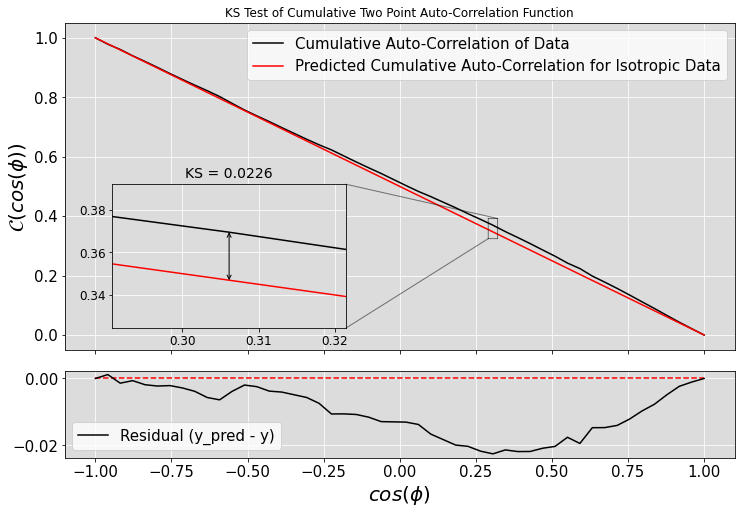

In [11]:
# Plot the KS test visually ------

# Create fig
fig, ax = plt.subplots(nrows=2, figsize=(12,8), sharex=True, 
                       gridspec_kw = {'height_ratios': [1.5, 0.4], 'hspace': 0.1})

for i in range(2):
    ax[i].set_facecolor('gainsboro')
    ax[i].grid(color='white')

# Plot the two functions
ax[0].plot(x, y, color='k', label='Cumulative Auto-Correlation of Data')
ax[0].plot(x, y_pred, color='r', label='Predicted Cumulative Auto-Correlation for Isotropic Data')
ax[0].legend(prop={'size':15})

# Plot the residuals in subplot below
resi = y_pred-y
ax[1].plot(x, resi, color='k', label='Residual (y_pred - y)')
ax[1].hlines(0, x[0], x[-1], linestyle='dashed', color='r')
ax[1].legend(prop={'size':15})

# ---------- Plot zoom -------------
# Create extra axis
ax1 = fig.add_axes([0.18, 0.35, 0.27, 0.25]) # add_axes([x0, y0, width, height])
ax1.set_facecolor('gainsboro')
ax1.grid(color='white')
  
# Plot again
ax1.plot(x, y, color='k')
ax1.plot(x, y_pred ,color='r')

# Get supremum index
index = np.argmax(abs(resi))
ks_H0 = ks_test(y, y_pred)

# Adjust limits
if resi[index] > 0: # y_pred is highest at supremum
    ymin, ymax = y[index] - resi[index], y_pred[index] + resi[index]
            
if resi[index] < 0: # y is highest at supremum
    ymin, ymax = y_pred[index] + resi[index], y[index] - resi[index]
        
xmin, xmax = x[index] - 0.05 * x[index], x[index] + 0.05 * x[index]
        
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# Mark supremum
supremum = ConnectionPatch(xyA=(x[index], y_pred[index]), xyB=(x[index], y[index]), coordsA=ax1.transData, 
                           arrowstyle='<->', color='k')
fig.add_artist(supremum)
ax1.set_title(f'KS = {ks_H0:.4f}', color='k', fontsize=14)

# Add zoom lines
con1 = ConnectionPatch(xyA=(xmin, ymin), coordsA=ax[0].transData, xyB=(xmax, ymin), coordsB=ax1.transData, alpha=0.5)
con2 = ConnectionPatch(xyA=(xmax, ymax), coordsA=ax[0].transData, xyB=(xmax,ymax), coordsB=ax1.transData, alpha=0.5)

sq1 = ConnectionPatch(xyA=(xmin, ymin), xyB=(xmax, ymin), coordsA=ax[0].transData, alpha=0.5)
sq2 = ConnectionPatch(xyA=(xmin, ymax), xyB=(xmax, ymax), coordsA=ax[0].transData, alpha=0.5)
sq3 = ConnectionPatch(xyA=(xmin, ymin), xyB=(xmin, ymax), coordsA=ax[0].transData, alpha=0.5)
sq4 = ConnectionPatch(xyA=(xmax, ymin), xyB=(xmax, ymax), coordsA=ax[0].transData, alpha=0.5)

fig.add_artist(con1)
fig.add_artist(con2)
fig.add_artist(sq1)
fig.add_artist(sq2)
fig.add_artist(sq3)
fig.add_artist(sq4)
# ----------------------------------

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)

ax[1].set_xlabel(r'$cos(\phi)$', fontsize=20)
ax[0].set_ylabel(r'$\mathcal{C}(cos(\phi))$', fontsize=20)

ax[0].set_title('KS Test of Cumulative Two Point Auto-Correlation Function')

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/2a_3.pdf')
    
plt.show()

## P-value from pseudo-experiments
The idea is now to simulate many isotropiccaly distributed data, and find their ks value by comparing it to the predicted isotropic. We can then calculate a p value from the distribution of ks-value, that tells us the likelihood of obtaining the KS test of 0.0163 that we got.

In [12]:
# Define a function to simulate isotropic data
def sample_isotropic(seed, N_points=len(data)):
    
    # Set seed
    np.random.seed(seed)
    
    # Sample from distributions
    MC_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points)
    MC_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points)
    MC_zeni = np.arccos(MC_cos_zeni)
    
    return MC_azim, MC_zeni

# Define a function that calculates the KS_test for many data sets
def sample_KS(N_samples, N_points):
    
    # Array to store KS val in
    KS_arr = []
    
    # Loop over samples
    for i in tqdm(range(N_samples)):
    
        # Produce sample of isotropic data
        MC_azim, MC_zeni = sample_isotropic(i*100, N_points)
        
        # Get two point correlation func
        x, y, y_pred = two_point_func(MC_azim, MC_zeni)
        
        # Get KS val
        KS_val = np.max( np.abs(y_pred-y) )
        KS_arr.append(KS_val)
        
    return KS_arr

In [13]:
# We produce 5000 experiments
N_experiments = 5000
KS_experiments = sample_KS(N_experiments, len(azim))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
# Calculate the p-value (integrating number of events above cut divided by events below)
def compute_p_val(crit_val, sample):
    """
    crit_val = the critical val to compute p from
    sample = the data
    """
    
    return np.sum(sample >= crit_val) / len(sample)

p_iso = compute_p_val(ks_H0, KS_experiments)
print(f'p-value for isotropic: {p_iso}')

p-value for isotropic: 0.0042


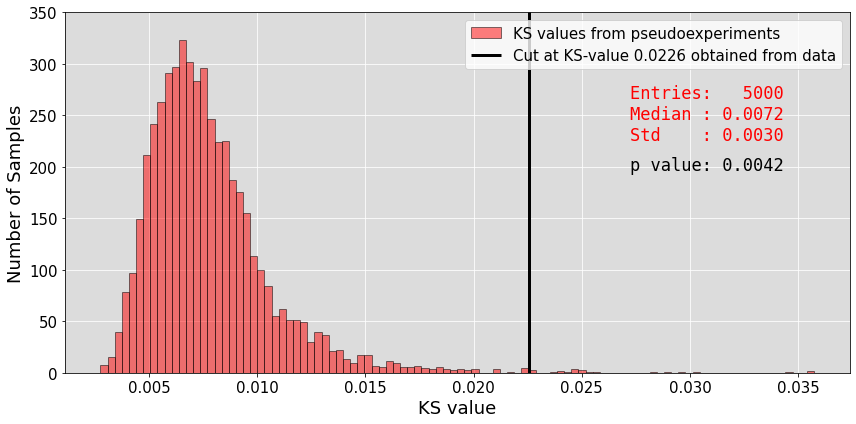

In [15]:
# Create figure to demonstrate the finding of the p-value
fig, ax = plt.subplots(figsize=(12,6))
ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Plot distribution of KS-values
bins_arr = np.arange(0,0.035,0.0005)
ax.hist(KS_experiments, color='red', ec='k', alpha=0.5, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments')

# Plot the cut
ax.vlines(ks_H0, 0, 350, color='k', linewidth=3, zorder=3,
          label=f'Cut at KS-value {ks_H0:.4f} obtained from data')

# Display the pvalue and other specs
d = {r'Entries:': len(KS_experiments),
     r'Median :': np.median(KS_experiments),
     r'Std    :': np.std(KS_experiments)
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.72, 0.8, text, ax, fontsize=17, color='red')
d = {r'p value:': p_iso,
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.72, 0.6, text, ax, fontsize=17, color='k')

plt.ylim(0,350)
ax.legend(prop={'size':15})
ax.set_xlabel('KS value', fontsize=18)
ax.set_ylabel('Number of Samples', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/2a_4.pdf')
    
plt.show()

# Problem 2B

In [16]:
# Define a function to simulate data from hypothesis A
def sample_HA(seed, N_points=len(data)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.2 * N_points)
    
    # Define uniform range
    uni_azim_range = (0.225*np.pi, 0.725*np.pi)
    uni_zeni_range = (0.30*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni

# Define a function to simulate data from hypothesis B
def sample_HB(seed, N_points=len(data)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.15 * N_points)
    
    # Define uniform range
    uni_azim_range = (0*np.pi, 1*np.pi)
    uni_zeni_range = (0.5*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni

# Define a function that calculates the KS_test for many data sets simmulated from HA
def sample_KS_HA(N_samples, N_points):
    
    # Array to store KS val in
    KS_arr = []
    
    # Loop over samples
    print('------- SAMPLING HA -------')
    for i in tqdm(range(N_samples)):
    
        # Produce sample of isotropic data
        MC_azim, MC_zeni = sample_HA(i*100, N_points)
        
        # Get two point correlation func
        x, y, y_pred = two_point_func(MC_azim, MC_zeni)
        
        # Get KS val
        KS_val = np.max( np.abs(y_pred-y) )
        KS_arr.append(KS_val)
        
    return KS_arr

# Define a function that calculates the KS_test for many data sets simmulated from HB
def sample_KS_HB(N_samples, N_points):
    
    # Array to store KS val in
    KS_arr = []
    
    # Loop over samples
    print('------- SAMPLING HB -------')
    for i in tqdm(range(N_samples)):
    
        # Produce sample of isotropic data
        MC_azim, MC_zeni = sample_HB(i*100, N_points)
        
        # Get two point correlation func
        x, y, y_pred = two_point_func(MC_azim, MC_zeni)
        
        # Get KS val
        KS_val = np.max( np.abs(y_pred-y) )
        KS_arr.append(KS_val)
        
    return KS_arr

In [17]:
# We produce 5000 experiments for each of the hypothesis (we already sampled isotropically)
N_experiments = 5000
KS_HA_experiments = sample_KS_HA(N_experiments, len(azim))
KS_HB_experiments = sample_KS_HB(N_experiments, len(azim))

------- SAMPLING HA -------


  0%|          | 0/5000 [00:00<?, ?it/s]

------- SAMPLING HB -------


  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
# Calculate p-values with respect to isotropic data
p_iso_HA = compute_p_val(np.median(KS_HA_experiments), KS_experiments)
p_iso_HB = compute_p_val(np.median(KS_HB_experiments), KS_experiments)
print('is HA hypothesis compatible with isotropic sampling H0?')
print('p_iso_HA:', p_iso_HA)
print('is HB hypothesis compatible with isotropic sampling H0?')
print('p_iso_HB:', p_iso_HB)

print('------------------')

# Calculate p-values with respect to the real data
p_data_HA = compute_p_val(ks_H0, KS_HA_experiments)
p_data_HB = compute_p_val(ks_H0, KS_HB_experiments)
print('is HA hypothesis compatible with the data?')
print('p_data_HA:', p_data_HA)
print('is HB hypothesis compatible with the data')
print('p_data_HB:', p_data_HB)

is HA hypothesis compatible with isotropic sampling H0?
p_iso_HA: 0.0122
is HB hypothesis compatible with isotropic sampling H0?
p_iso_HB: 0.0846
------------------
is HA hypothesis compatible with the data?
p_data_HA: 0.3274
is HB hypothesis compatible with the data
p_data_HB: 0.1144


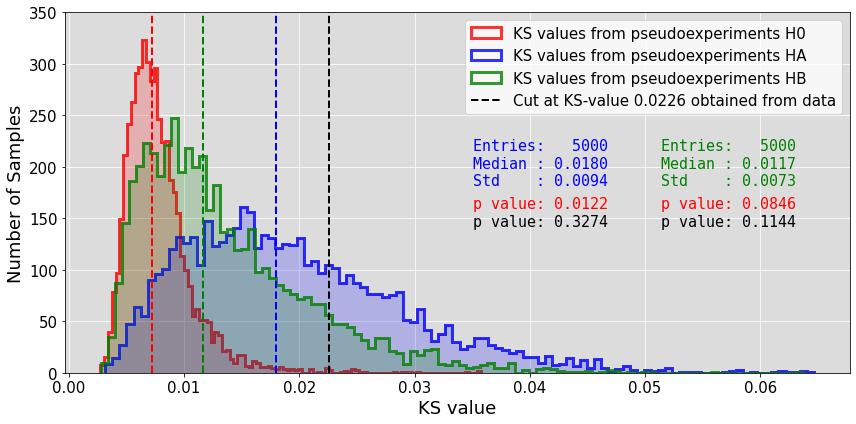

In [19]:
# Plot it all together

# Create figure to demonstrate the finding of the p-value
fig, ax = plt.subplots(figsize=(12,6))
ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Plot distribution of KS-values
bins_arr = np.arange(0,0.035,0.0005)
ax.hist(KS_experiments, color='red', histtype='step', alpha=0.8, linewidth=3, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments H0')
ax.hist(KS_experiments, color='red', alpha=0.2, bins=100, zorder=2)

ax.hist(KS_HA_experiments, color='blue', histtype='step', alpha=0.8, linewidth=3, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments HA')
ax.hist(KS_HA_experiments, color='blue', alpha=0.2, bins=100, zorder=2)

ax.hist(KS_HB_experiments, color='green', histtype='step', alpha=0.8, linewidth=3, bins=100, zorder=2,
        label=f'KS values from pseudoexperiments HB')
ax.hist(KS_HB_experiments, color='green', alpha=0.2, bins=100, zorder=2)

# Plot the cut
ax.vlines(ks_H0, 0, 350, color='k', linewidth=2, zorder=3, linestyle='dashed',
          label=f'Cut at KS-value {ks_H0:.4f} obtained from data')

# Mark medians
ax.vlines(np.median(KS_experiments), 0, 350, color='r', linewidth=2, zorder=3, linestyle='dashed')
ax.vlines(np.median(KS_HA_experiments), 0, 350, color='b', linewidth=2, zorder=3, linestyle='dashed')
ax.vlines(np.median(KS_HB_experiments), 0, 350, color='g', linewidth=2, zorder=3, linestyle='dashed')


# Display the pvalue and other specs
d = {r'Entries:': len(KS_HA_experiments),
     r'Median :': np.median(KS_HA_experiments),
     r'Std    :': np.std(KS_HA_experiments),
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.52, 0.65, text, ax, fontsize=15, color='blue')
d = {r'p value:': p_iso_HA,
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.52, 0.49, text, ax, fontsize=15, color='r')
d = {r'p value:': p_data_HA,
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.52, 0.44, text, ax, fontsize=15, color='k')
# --------------------
d = {r'Entries:': len(KS_HB_experiments),
     r'Median :': np.median(KS_HB_experiments),
     r'Std    :': np.std(KS_HB_experiments),
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.76, 0.65, text, ax, fontsize=15, color='green')
d = {r'p value:': p_iso_HB,
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.76, 0.49, text, ax, fontsize=15, color='r')
d = {r'p value:': p_data_HB,
    }
text = AppStars.nice_string_output(d, extra_spacing=1, decimals=4)
AppStars.add_text_to_ax(0.76, 0.44, text, ax, fontsize=15, color='k')
# ------------------------

plt.ylim(0,350)
ax.legend(prop={'size':15})
ax.set_xlabel('KS value', fontsize=18)
ax.set_ylabel('Number of Samples', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/2a_5.pdf')
    
plt.show()